In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [2]:
from model import *

In [3]:
from dataset import get_data_loader
from torchvision import transforms
from utils import ScaleImageByHeight
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import ImageGrid
import skimage
import math
from PIL import ImageOps

In [10]:
device = 'cuda:0'
CKPT = 'runs/02-04-2020_20-44-07_tf_vnondb_line_resnet_scale96_randrotation10_petext_peimage_encoder/weights/BEST.pt'

print('Device = {}'.format(device))
print('Load weight from {}'.format(CKPT))
checkpoint = torch.load(CKPT, map_location=device)
root_config = checkpoint['config']

config = root_config['common']

image_transform = transforms.Compose([
    ImageOps.invert,
    ScaleImageByHeight(config['scale_height']),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
])

test_loader = get_data_loader(config['dataset'], 'test', 4,
                              1,
                              image_transform)
vocab = test_loader.dataset.vocab
print('Vocab size = {}'.format(vocab.size))

if config['cnn'] == 'densenet':
    cnn_config = root_config['densenet']
    cnn = DenseNetFE('densenet161', True)
elif config['cnn'] == 'squeezenet':
    cnn = SqueezeNetFE()
elif config['cnn'] == 'efficientnet':
    cnn = EfficientNetFE('efficientnet-b1')
elif config['cnn'] == 'custom':
    cnn = CustomFE(3)
elif config['cnn'] == 'resnet':
    cnn = ResnetFE('resnet18')
else:
    raise ValueError('Unknow CNN {}'.format(config['cnn']))

model_config = root_config['tf']
if model_config['use_encoder']:
    model = ModelTFEncoder(cnn, vocab, model_config)
else:
    model = ModelTF(cnn, vocab, model_config)
model.to(device)
model.load_state_dict(checkpoint['model'])

print('Ok')

Device = cuda:0
Load weight from runs/02-04-2020_20-44-07_tf_vnondb_line_resnet_scale96_randrotation10_petext_peimage_encoder/weights/BEST.pt
Vocab size = 162
Ok


In [11]:
named_modules = {}
def hook_weight_fn(module, inputs, outputs):
    # named_modules[module]['output'].append(outputs[1][:, [-1]].cpu())
    named_modules[module]['output'] = outputs[1].cpu()

feature_size = tuple()
def hook_feature_size(module, inputs, outputs):
    global feature_size
    feature_size = outputs.shape

for name, module in model.named_modules():
    if isinstance(module, nn.MultiheadAttention):
        named_modules[module] = {
            'name': name,
            'output': None,
        }
        module.register_forward_hook(hook_weight_fn)
    elif isinstance(module, (ResnetFE, DenseNetFE)):
        module.register_forward_hook(hook_feature_size)


In [12]:
print(model)

ModelTFEncoder(
  (cnn): ResnetFE(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [13]:
iter_test_loader = iter(test_loader)

In [14]:
model.eval()
with torch.no_grad():
    batch = next(iter_test_loader)
    imgs, targets = batch.images.to(device), batch.labels.to(device)
    outputs = model.greedy(imgs, targets[:,0], 150)
    outputs, targets = outputs, targets[:, 1:]
    outputs = outputs.cpu()
    targets = targets.cpu()

torch.Size([4, 512, 3, 69])


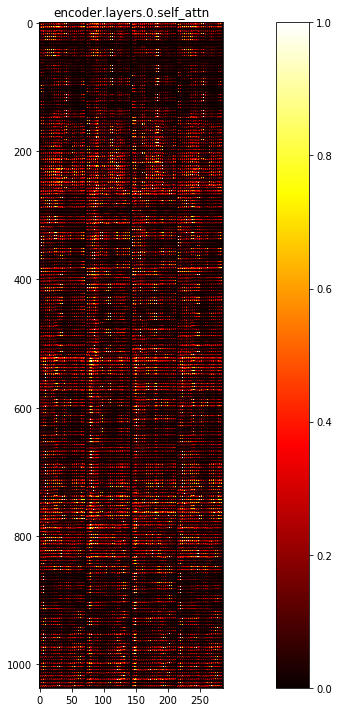

In [30]:
figure, axes = plt.subplots(1, 1, squeeze=False, figsize=(15,10))
print(feature_size)
h, w = feature_size[-2:]

j = 0
for i, (key, value) in enumerate(named_modules.items()):
    title = value['name']
    weight = value['output']
    if title.startswith('encoder') and title.endswith('self_attn'):
        # normalize by row
        weight = (weight - weight.min(-1, keepdim=True)[0]) / ((weight - weight.min(-1, keepdim=True)[0]).max(-1, keepdim=True)[0])
        weight = weight.unsqueeze(1)
        weight = weight.reshape(-1, 1, h, w)
        weight_image = torchvision.utils.make_grid(weight, nrow=4, pad_value=0)
        axes[j, 0].set_title(title)
        img = axes[j, 0].imshow(weight_image[0], cmap='hot')
        plt.colorbar(img, use_gridspec=True)
        j += 1
plt.tight_layout()
plt.show()
    

torch.Size([4, 512, 3, 69])
torch.Size([4, 1, 84, 84])


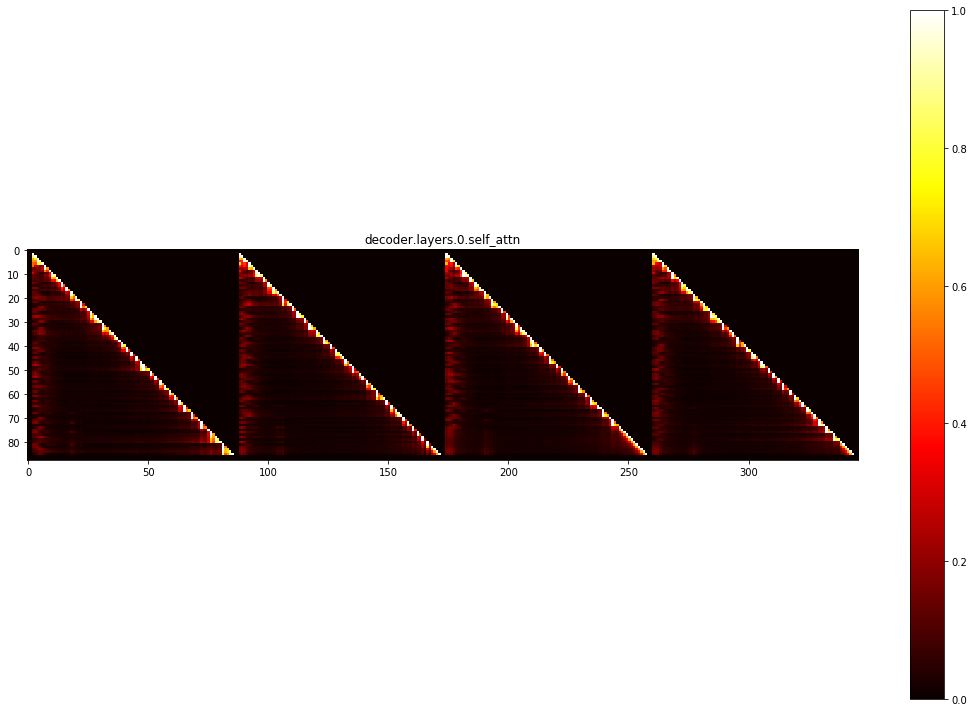

In [26]:
figure, axes = plt.subplots(1, 1, squeeze=False, figsize=(15,10))
print(feature_size)
h, w = feature_size[-2:]

j = 0
for i, (key, value) in enumerate(named_modules.items()):
    title = value['name']
    weight = value['output']
    if title.startswith('decoder') and title.endswith('self_attn'):
        # normalize by row
        weight = (weight - weight.min(-1, keepdim=True)[0]) / ((weight - weight.min(-1, keepdim=True)[0]).max(-1, keepdim=True)[0])
        weight = weight.unsqueeze(1)
        print(weight.shape)
        # weight = weight.reshape(-1, 1, h, w)
        weight_image = torchvision.utils.make_grid(weight, nrow=8, pad_value=0)
        axes[j, 0].set_title(title)
        img = axes[j, 0].imshow(weight_image[0], cmap='hot')
        plt.colorbar(img, use_gridspec=True)
        j += 1
plt.tight_layout()
plt.show()
    

torch.Size([4, 512, 3, 69])


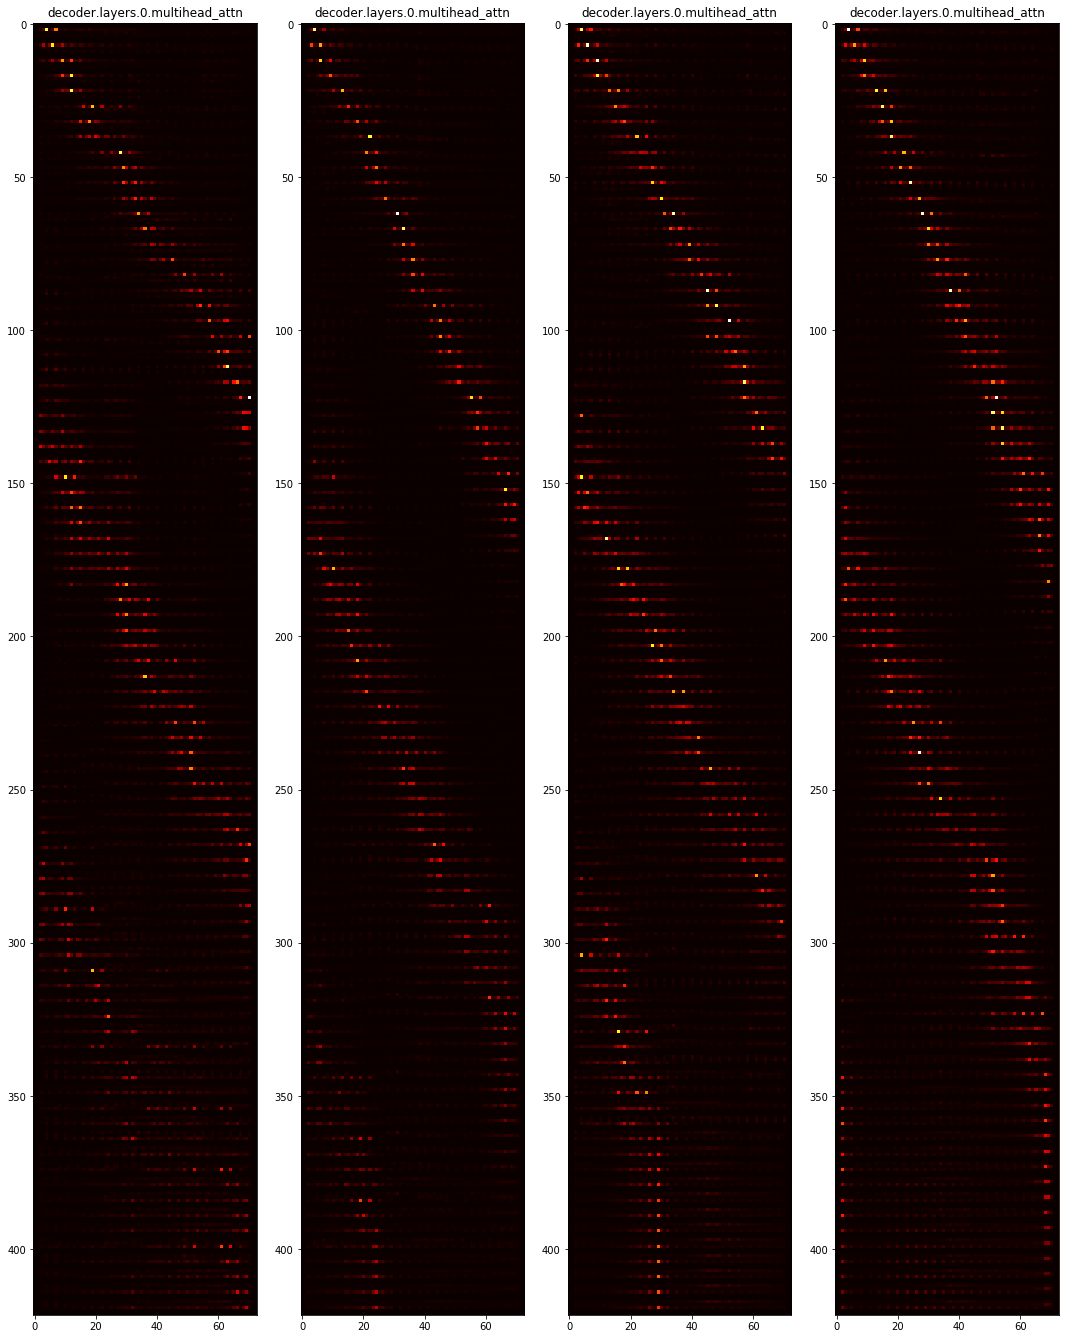

In [24]:
figure, axes = plt.subplots(1, len(outputs), squeeze=False, figsize=(15,20))
print(feature_size)
h, w = feature_size[-2:]

for key, value in named_modules.items():
    title = value['name']
    weight = value['output']
    if title.split('.')[-1] == 'multihead_attn':
        for i, weight_sample in enumerate(weight):
            weight_sample = weight_sample.reshape(-1, 1, h, w)
            weight_image = torchvision.utils.make_grid(weight_sample, nrow=1, pad_value=0)

            axes[0, i].set_title(title)
            axes[0, i].imshow(weight_image[0], cmap='hot')

plt.tight_layout()
plt.show()
    

In [44]:
vocab = test_loader.dataset.vocab
for pred, tgt in zip(outputs.tolist(), batch.labels[:,1:].tolist()):
    try:
        pred_end_index = pred.index(vocab.char2int(vocab.EOS))
    except:
        pred_end_index = len(pred)
    print(pred_end_index)
    pred = ''.join(list(map(vocab.int2char, pred[:pred_end_index])))

    try:
        tgt_end_index = tgt.index(vocab.char2int(vocab.EOS))
    except:
        tgt_end_index = len(tgt)
    tgt = ''.join(list(map(vocab.int2char, tgt[:tgt_end_index])))
    print(f'{pred}\n{tgt}')
    print()


83
Công gà 200 năm làm nhà tình thuyng. Tới gặp ông văn Cảm Các Công chị chọ Sang long
Ông già 30 năm làm nhà tình thương. Tôi gặp ông Lê Văn On (Tám On) ngụ ở ấp Tiên Long

79
Bộ, xã Tuân Công, huyện Quâu Thành Liến Tra là người bảo chiều của, các cất gầu
1, xã Tiên Long, huyện Châu Thành, Bến Tre là người bỏ nhiều công, của cất gần

72
nói về việc làm tì thiệu của mình. ông tâm viện là làm việc thìn thà thà
nói về việc làm từ thiện của mình. Ông tâm niệm là làm việc thiện thì kể

68
Sao cản nhà tình thương dong người nghào khả khân lắn giới được được
600 căn nhà tình thương cho người nghèo. Khó khăn lắm mới gợi được ông

